# Setup

In [2]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# Imports

import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint
from utils import get_wiki_dataset
from utils import get_compute_metrics_func
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



2022-12-29 22:34:07.575168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 22:34:14.039381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-29 22:34:14.040544: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-29 22:34:14.040554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
# beautify graphs.

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes

palatte=sns.color_palette('pastel')
palatte

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [5]:
# Load GPT2 model fine-tuned on writing prompts

gpt2_modelfile = 'gpt2-xl'
model_args = ModelArguments(
    model_name_or_path=gpt2_modelfile,   
)
gpt2_model = get_model(model_args)
gpt2_model.to('cuda')
tokenizer = get_tokenizer(model_args)
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = gpt2_model.to('cuda')

In [6]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [7]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, label=None, ax=None,  color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    ax = sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [8]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/orig.jsonl'
gpt2_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/greedy.jsonl"
gpt2_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5.jsonl"
gpt2_nucleus_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/top_p_0.9.jsonl"
gpt2_temp_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/temp_0_8.jsonl"
gpt2_topk_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/top_k_30.jsonl"
gpt2_typical_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/typical_p_0.9.jsonl"
gpt2_ead_v4_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v4_typical_0.2.jsonl"

# gpt2_entropy_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5_eab.jsonl"
# gpt2_eags_v1_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis/eags_v4_typical_tau_0.2_upper_3.5_lower_2.5_patience_6.jsonl"
# gpt2_eags_v2_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v2_k_30.jsonl"
# gpt2_eags_v3_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v3_k_30.jsonl"

In [9]:
NUM_SEQ=2000
MAX_LEN = 128
WIDTH = 5

# Entropy of Human Data

In [10]:
human_dataframe = pd.read_json(orig_wp, lines=True)\
                        .rename(columns={'prefix':'context', 
                                         'target': 'model_text'})

In [11]:
human_dataframe['model_text'].str.split().apply(len)

0       83
1       68
2       81
3       70
4       86
        ..
7708    93
7709    83
7710    97
7711    78
7712    53
Name: model_text, Length: 7713, dtype: int64

In [23]:
human_datapoint = human_dataframe[human_dataframe['model_text'].str.split().apply(len) > 40][human_dataframe['model_text'].str.split().apply(len) < 50].sample().iloc[0]
print(human_datapoint.model_text)
print()
print_sample(human_datapoint.context, human_datapoint.model_text)

len(human_datapoint['model_text'])


The journalist Harlan McKosato said in 1999, "...her [Aquash's] death has divided the American Indian Movement..." The schism continued, with the national AIM leadership claiming that the local AIM leaders, such as Churchill, are tools of the U.S. government used against other American Indians.

The journalist Harlan McKosato said in 1999, "...her [Aquash's] death has divided the American Indian Movement..." The schism continued, with the national AIM leadership claiming that the local AIM leaders, such as Churchill, are tools of the U.S. government used against other American Indians.


/tmp/ipykernel_62325/2752344834.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  human_datapoint = human_dataframe[human_dataframe['model_text'].str.split().apply(len) > 40][human_dataframe['model_text'].str.split().apply(len) < 50].sample().iloc[0]


295

## Compute Average entropy across sequences.

In [13]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=7713, cache=True)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-128-2000-entropy-1-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-128-2000-entropy-1-avgs.csv
Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-128-7713-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-128-7713-entropy_ma-5-avgs.csv


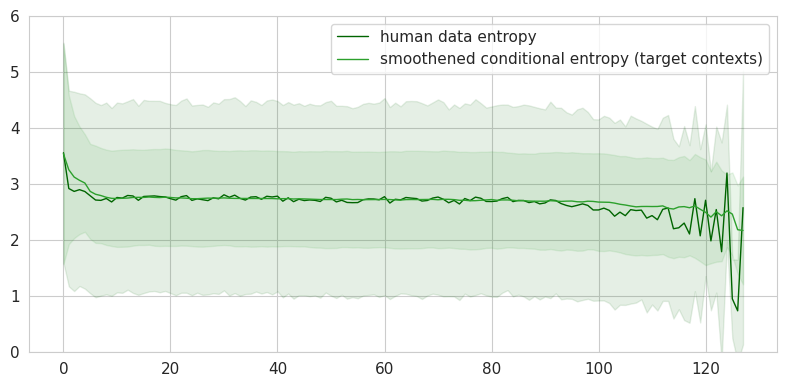

In [14]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
plot_avg_entropies_mean_std(human_entropies, 'human data entropy', color='darkgreen')
plot_avg_entropies_mean_std(human_ma_entropies, 'smoothened conditional entropy (target contexts)', ax=ax, color='tab:green', linewidth=1.0)

## Examples of generation

In [24]:
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,
)

Text(0, 0.5, 'Nats')

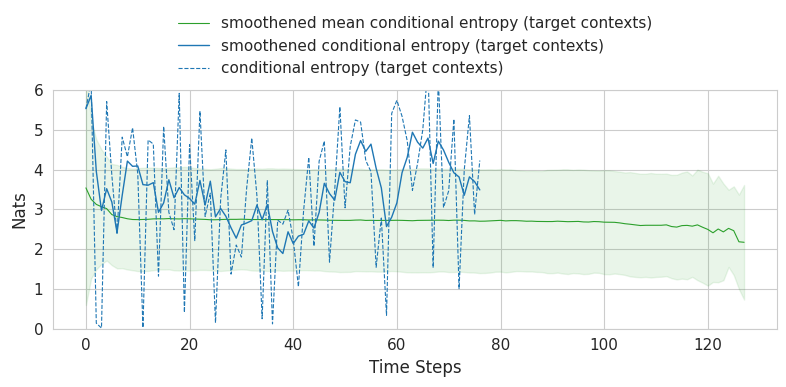

In [16]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

plot_avg_entropies_mean_std(human_ma_entropies, 'smoothened mean conditional entropy (target contexts)', ax=ax, color='tab:green', std_dev=1.5, linewidth=0.8)
lpdh.plot(x="index", y='entropy_ma',  ax=ax, color='tab:blue', linewidth=1.0, label="smoothened conditional entropy (target contexts)")
lpdh.plot(x="index", y='entropy', ax=ax, color='tab:blue', linewidth=0.8, label="conditional entropy (target contexts)", linestyle='dashed')
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=1, title=None, frameon=False)
ax.set_xlabel("Time Steps")
ax.set_ylabel("Nats")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


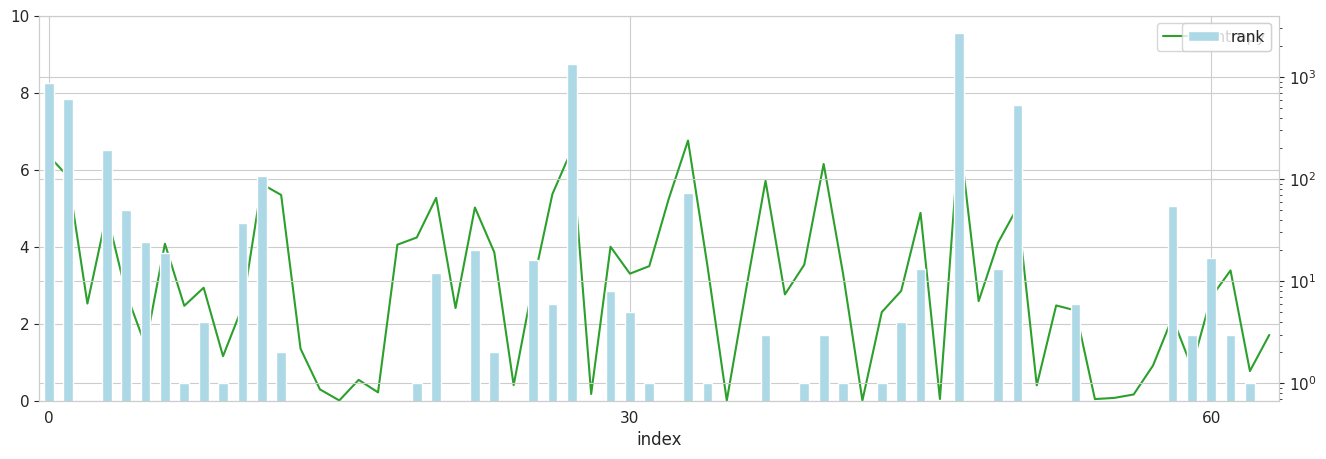

In [25]:
fig, ax = plt.subplots(figsize=(16, 5))
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2 = ax.twinx()
ax2.legend(loc=2)
ax2.set_yscale('log')

lpdh.plot.bar(x="index", y='rank', ax=ax2, color='lightblue', )
lpdh.plot(x="index", y='entropy', ylim=(0,10), ax=ax, color='tab:green')

ax.set_xticks(np.arange(len(lpdh['index']), step=30))



# Entropy of Model Data

In [12]:
model_greedy_dataframe = pd.read_json(gpt2_greedy_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})
model_greedy_dataframe.dropna(inplace=True)

model_beam_dataframe = pd.read_json(gpt2_beam_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_temp_dataframe = pd.read_json(gpt2_temp_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_nucleus_dataframe = pd.read_json(gpt2_nucleus_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_topk_dataframe = pd.read_json(gpt2_topk_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_typical_dataframe = pd.read_json(gpt2_typical_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_ead_v4_dataframe = pd.read_json(gpt2_ead_v4_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

# model_eags_v2_dataframe = pd.read_json(gpt2_eags_v2_generation, lines=True)\
#                                 .rename(columns={'prefix':'context', 
#                                                  'generation': 'model_text'})
                                                 
# model_eags_v3_dataframe = pd.read_json(gpt2_eags_v3_generation, lines=True)\
#                                 .rename(columns={'prefix':'context', 
#                                                  'generation': 'model_text'})
# model_eabs_dataframe = pd.read_csv(gpt2_entropy_beam_generation, sep='\t', names=['context', 'model_text', 'voilations', 'entropies'])


In [18]:
human_datapoint = human_dataframe[human_dataframe['model_text'].str.split().apply(len) > 20][human_dataframe['model_text'].str.split().apply(len) < 30].iloc[1]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

print(human_datapoint_idx)

human_datapoint_idx=32

319


/tmp/ipykernel_39285/3430327020.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  human_datapoint = human_dataframe[human_dataframe['model_text'].str.split().apply(len) > 20][human_dataframe['model_text'].str.split().apply(len) < 30].iloc[1]


In [30]:
human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe[model_greedy_dataframe.context == human_datapoint.context].iloc[0]
beam_sample = model_beam_dataframe[model_beam_dataframe.context == human_datapoint.context].iloc[0]
temp_sample = model_temp_dataframe[model_temp_dataframe.context == human_datapoint.context].iloc[0]
nucleus_sample = model_nucleus_dataframe[model_nucleus_dataframe.context == human_datapoint.context].iloc[0]
topk_sample = model_topk_dataframe[model_topk_dataframe.context == human_datapoint.context].iloc[0]
typical_sample = model_typical_dataframe[model_typical_dataframe.context == human_datapoint.context].iloc[0]
ead_v4_sample = model_ead_v4_dataframe.iloc[human_datapoint_idx]
# eag_v2_sample = model_eags_v2_dataframe.iloc[human_datapoint_idx]
# eag_v3_sample = model_eags_v3_dataframe.iloc[human_datapoint_idx]

# eabs_sample = model_eabs_dataframe.iloc[human_datapoint_idx * 10]

print("Context:")
print(human_datapoint.context)
print()
print("Target:")
print(human_datapoint.model_text)
print()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text)
print()
print("Beam Model Text: ")
print_sample(human_datapoint.context, beam_sample.model_text)
print()
print("Temperature sampled Model Text:")
print_sample(human_datapoint.context, temp_sample.model_text)
print()
print("Nucleus sampled Model Text:")
print_sample(human_datapoint.context, nucleus_sample.model_text)
print()
print("Top-K sampled Model Text:")
print_sample(human_datapoint.context, topk_sample.model_text)
print()

print("Typical Model Text: ")
print_sample(human_datapoint.context, typical_sample.model_text)
print()

print("EAD Model Text:")
print_sample(human_datapoint.context, ead_v4_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

# print("EAG Model V2 Text:")
# print_sample(human_datapoint.context, eag_v2_sample.model_text)
# # print(f"Num. Voilations: {eag_sample.voilations}")
# print()

# print("EAG Model V3 Text:")
# print_sample(human_datapoint.context, eag_v3_sample.model_text)
# # print(f"Num. Voilations: {eag_sample.voilations}")
# print()

# print("EABS Model Text:")
# print_sample(human_datapoint.context, eabs_sample.model_text.replace("\n", "\\n"))
# print(f"Num. Voilations: {eabs_sample.voilations}")
# print()

Context:
From there east, it was numbered just M‑48, removing US 2 from a concurrency. Another former section into Epoufette was added to extend M‑117. The new highway was detoured around the Cut River Bridge until it was completed in 1946 after construction delays over steel shortages during World War II. The western end of US 2 took on two changes in the 1940s. M‑28 was extended along US 2 to the state line at Ironwood from its western terminus at Wakefield. A similar extension was made from M‑28's eastern terminus to Sault Ste. Marie in 1948. The M‑54 designation was renumbered as Business US 2 by 1945. The eastern M‑28 extension was reversed in 1950, and the western extension to the state line was shifted to a new location by 1952. With the coming of the Interstate Highway System in Michigan, the MSHD planned to convert the eastern section of US 2 to a freeway between St. Ignace and Sault Ste. Marie. In planning maps from 1947, this highway corridor was included in the system that 

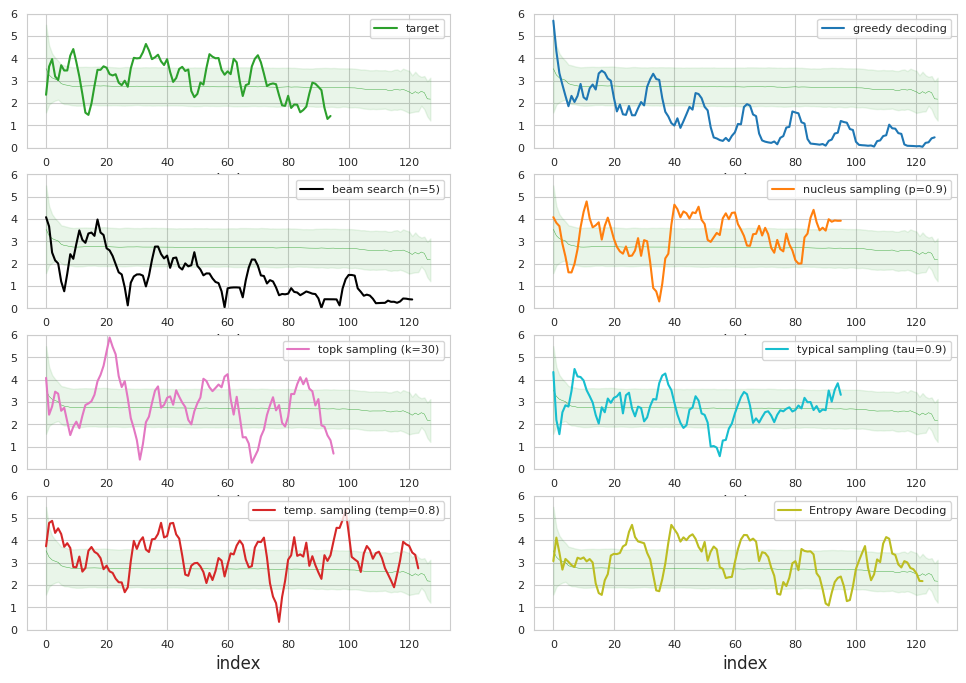

In [31]:
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

temp_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=temp_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

ead_v4_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

# eag_v2_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eag_v2_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eag_v3_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=eag_v3_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eabs_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eabs_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

fig, axs = plt.subplots(4,2, figsize=(12, 8))
plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0, 0], color='tab:green', std_dev=1.0, linewidth=0.3)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')
axs[0,0].legend(fontsize=8, loc="upper right")
axs[0,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[0, 1], color='tab:green', std_dev=1.0, linewidth=0.3)
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 1], label='greedy decoding', color='tab:blue')
axs[0, 1].legend(fontsize=8, loc="upper right")
axs[0, 1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1, 0], color='tab:green', std_dev=1.0, linewidth=0.3)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1, 0], label='beam search (n=5)', color='black')
axs[1, 0].legend(fontsize=8, loc="upper right")
axs[1, 0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1, 1], color='tab:green', std_dev=1.0, linewidth=0.3)
nucleus_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1, 1], label='nucleus sampling (p=0.9)', color='tab:orange')
axs[1, 1].legend(fontsize=8, loc="upper right")
axs[1, 1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[2,0], color='tab:green', std_dev=1.0, linewidth=0.3)
topk_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2,0], label='topk sampling (k=30)', color='tab:pink')
axs[2,0].legend(fontsize=8, loc="upper right")
axs[2,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[2,1], color='tab:green', std_dev=1.0, linewidth=0.3)
typical_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2,1], label='typical sampling (tau=0.9)', color='tab:cyan')
axs[2,1].legend(fontsize=8, loc="upper right")
axs[2,1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[3,0],  color='tab:green', std_dev=1.0, linewidth=0.3)
temp_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 0], label='temp. sampling (temp=0.8)', color='tab:red')
axs[3, 0].legend(fontsize=8, loc="upper right")
axs[3, 0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[3,1], color='tab:green', std_dev=1.0, linewidth=0.3)
ead_v4_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 1], label='Entropy Aware Decoding', color='tab:olive')
axs[3, 1].legend(fontsize=8, loc="upper right")
axs[3, 1].tick_params(labelsize=8)

AttributeError: 'str' object has no attribute 'xaxis'

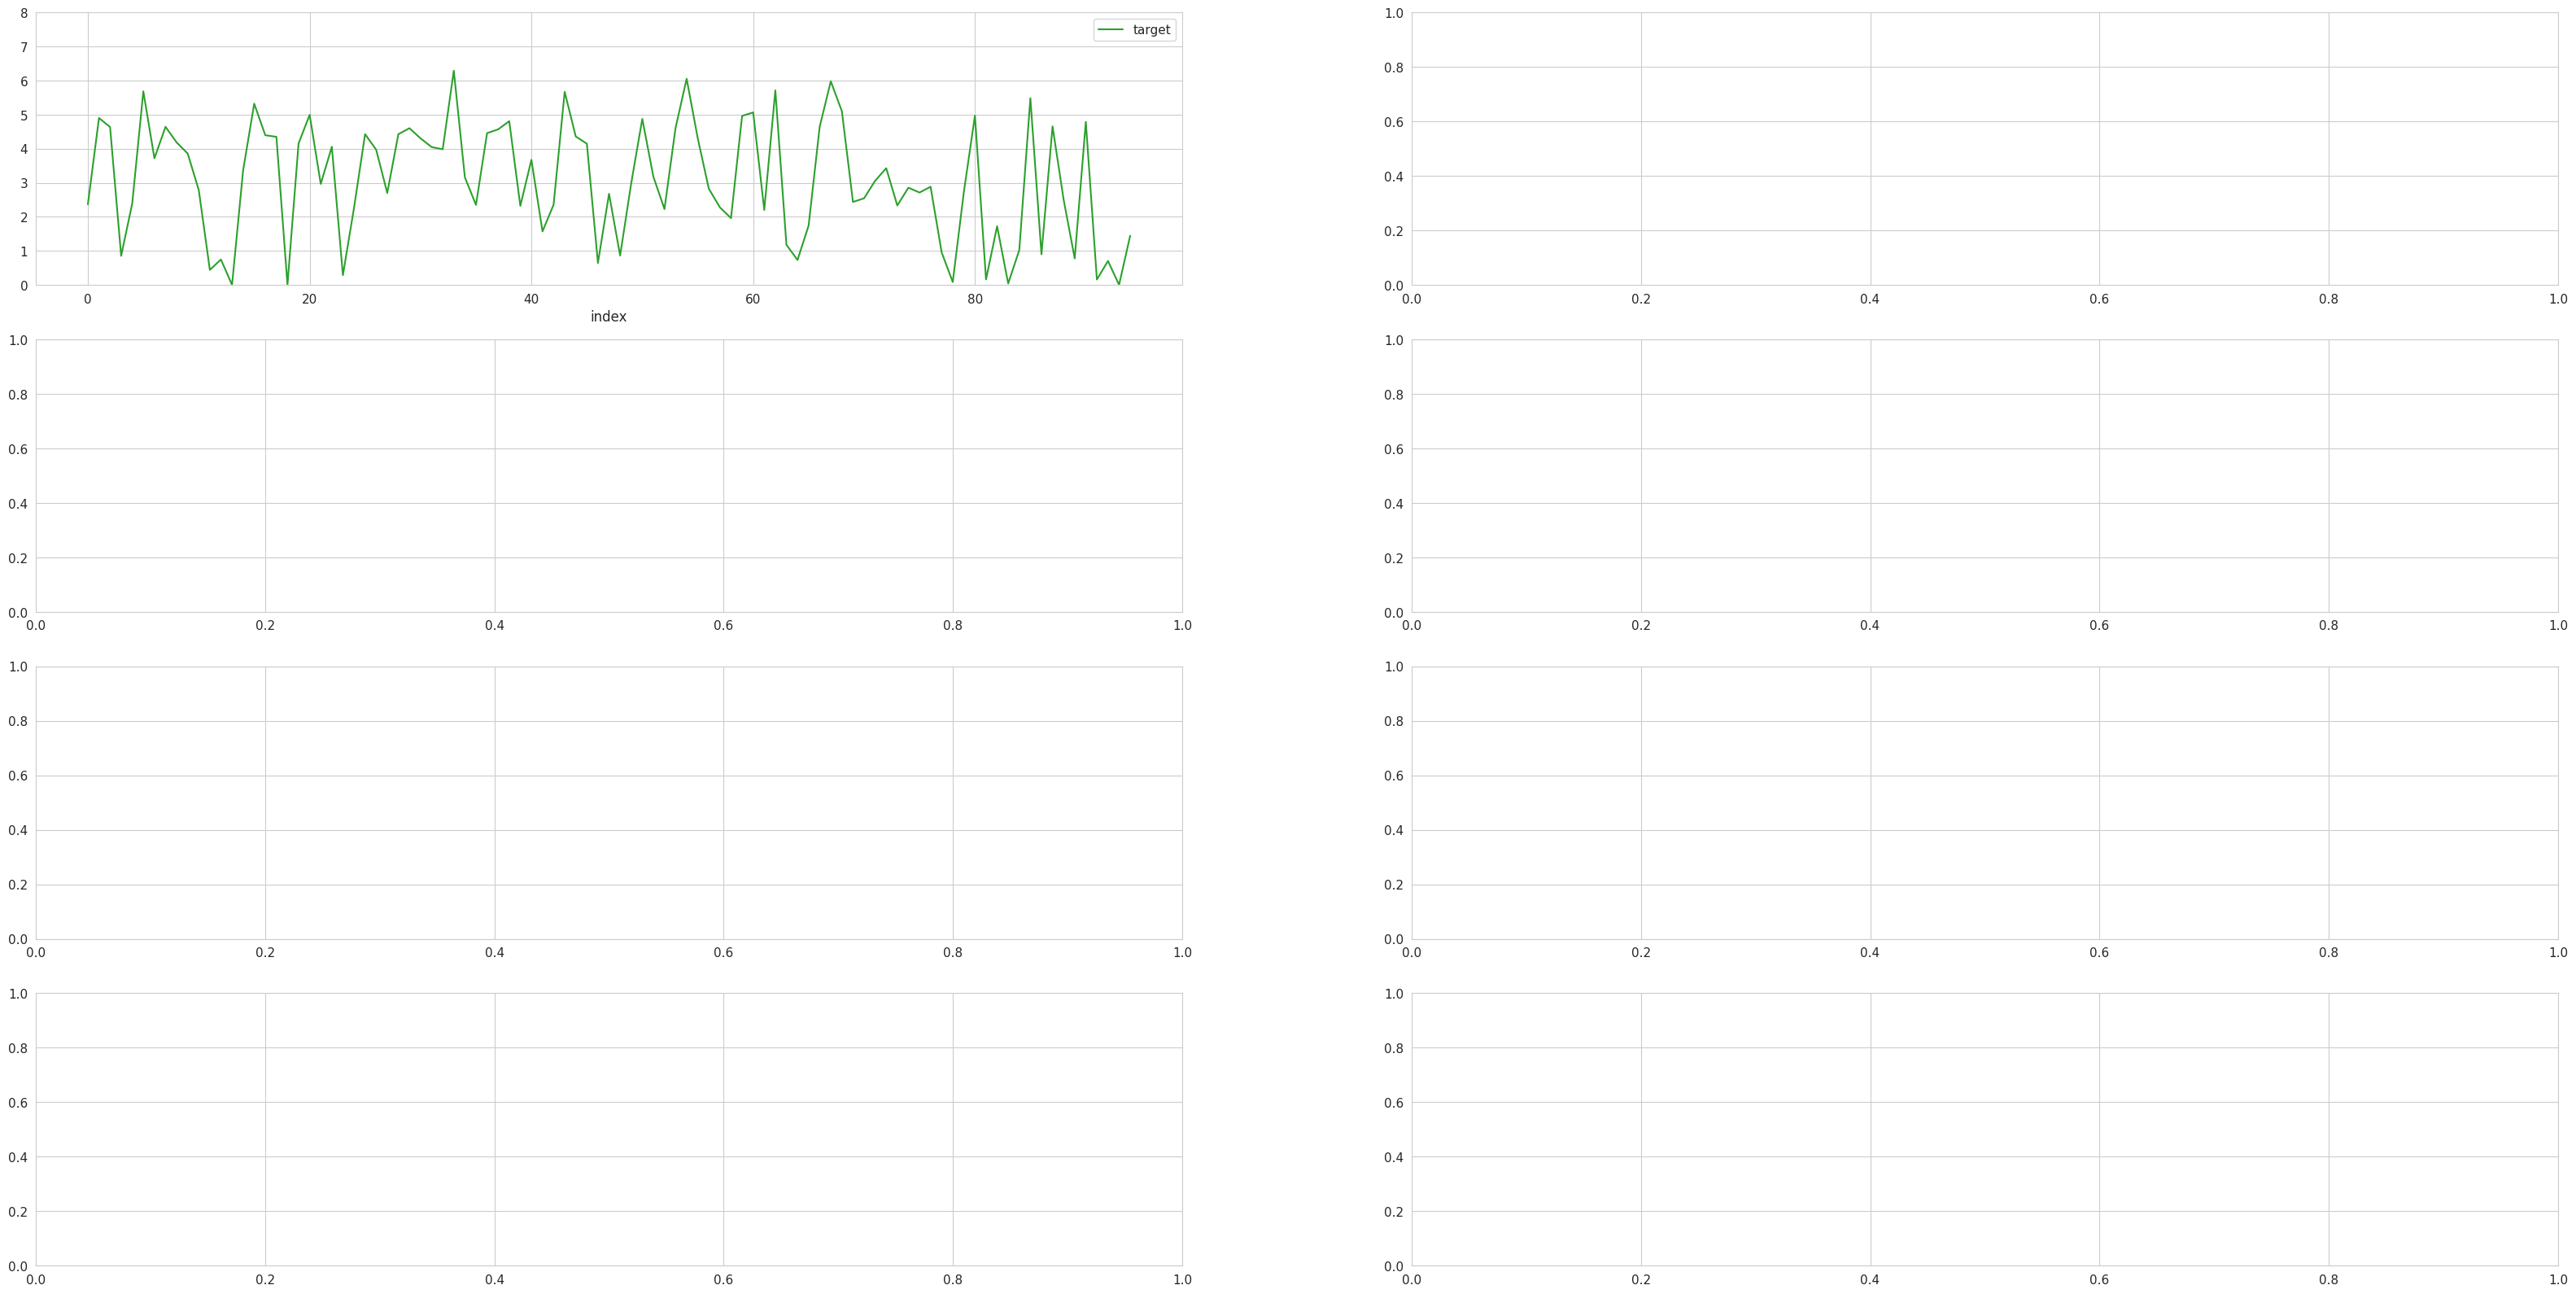

In [33]:
fig, axs = plt.subplots(4,2, figsize=(40, 20))
# plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=axs[0,0], label='target', color='tab:green')
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)

ax2 = axs[0,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
lpdh.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

greedy_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[0, 1], label='greedy decoding', color='tab:blue')
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[0,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
greedy_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

beam_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[1, 0], label='beam search', color='black')
plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[1,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
beam_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

nucleus_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[1, 1], label='nucleus sampling', color='tab:orange')
plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[1,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
nucleus_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

topk_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[2,0], label='topk sampling', color='tab:pink')
plot_avg_entropies_mean_std(human_ma_entropies, axs[2,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[2,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
topk_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')


typical_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[2,1], label='typical sampling', color='tab:cyan')
plot_avg_entropies_mean_std(human_ma_entropies, axs[2,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[2,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
typical_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

# eag_v2_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[3,0], label='EAGS V2', color='tab:cyan', linestyle='dashed')
# eag_v2_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,8), ax=axs[3,0], label='EAGS V2', color='tab:cyan')
# plot_avg_entropies_mean_std(human_ma_entropies, axs[3,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
# ax2 = axs[3,0].twinx()
# ax2.legend(loc=2)
# ax2.set_ylim((0,10))
# # ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
# eag_v2_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')


# eag_v3_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[3,1], label='EAGS V3', color='tab:cyan', linestyle='dashed')
# eag_v3_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,8), ax=axs[3,1], label='EAGS V3', color='tab:cyan')

# plot_avg_entropies_mean_std(human_ma_entropies, axs[3,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
# ax2 = axs[3,1].twinx()
# ax2.legend(loc=2)
# ax2.set_ylim((0,10))
# # ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
# eag_v3_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

plt.setp(axs, xticks=range(0, MAX_LEN, 5))


## Generate using Entropy Aware Greedy Search

In [ ]:
%%script false --no-raise-error

tokenizer.pad_token = tokenizer.eos_token

tokenized_context = tokenizer(human_datapoint.context, return_tensors="pt")
tokenized_context = tokenized_context.to('cuda')

gpt2_model.greedy_search(**tokenized_context, max_length=1024, pad_token_id=tokenizer.eos_token_id)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
%%script false --no-raise-error
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
test_dataloader = DataLoader(tokenized_writing_prompt_testset, collate_fn=data_collator, batch_size=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Compute Average entropy across timesteps.

### For all model generated data

In [56]:
# Greedy
# model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 39.25 GiB total capacity; 12.67 GiB already allocated; 10.31 MiB free; 12.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [54]:
# Beam
# model_gen_beam_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_beam_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/fcb9783db7fee4a8bc3cf601b10eea76-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_beam-128-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/fcb9783db7fee4a8bc3cf601b10eea76-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_beam-128-2000-entropy_ma-5-avgs.csv


In [53]:
# Nucleus
# model_gen_nucleus_avg_entropy_pd, model_gen_nucleus_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_nucleus_avg_ma_entropy_pd, model_gen_nucleus_ma_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/497350b28f282ba2092b558a4b5cc127-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_nucleus-128-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/497350b28f282ba2092b558a4b5cc127-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_nucleus-128-2000-entropy_ma-5-avgs.csv


In [17]:
# Topk
# model_gen_topk_avg_entropy_pd, model_gen_topk_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_topk_avg_ma_entropy_pd, model_gen_topk_ma_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/0d77afea9c4c6ed5256515712463d499-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_topk-128-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/0d77afea9c4c6ed5256515712463d499-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_topk-128-2000-entropy_ma-5-avgs.csv


In [18]:
# Typical Decoding
# model_gen_typical_avg_entropy_pd, model_gen_typical_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_typical_avg_ma_entropy_pd, model_gen_typical_ma_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_decoding', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/8eb6da3cc45f39cc72f562c56e3940bf-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_typical_decoding-128-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/8eb6da3cc45f39cc72f562c56e3940bf-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_typical_decoding-128-2000-entropy_ma-5-avgs.csv


In [19]:
model_gen_ead_avg_ma_entropy_pd, model_gen_ead_ma_entropies = compute_average_across_sequences(model_ead_v4_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_entropy_aware_decoding', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/99ccf867c1682af4351a5178ae46e90d-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_entropy_aware_decoding-128-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/99ccf867c1682af4351a5178ae46e90d-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_entropy_aware_decoding-128-2000-entropy_ma-5-avgs.csv


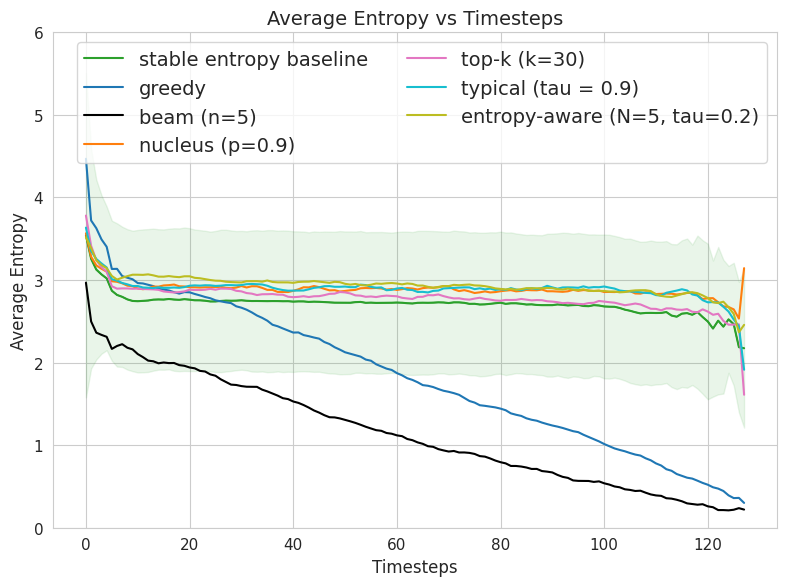

: 

In [66]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd,  model_gen_beam_avg_ma_entropy_pd, model_gen_nucleus_avg_ma_entropy_pd, model_gen_topk_avg_ma_entropy_pd, model_gen_typical_avg_ma_entropy_pd, model_gen_ead_avg_ma_entropy_pd],axis=1)

model_vs_human_avg_entropies = model_vs_human_avg_entropies.drop(["Unnamed: 0"], axis=1)

model_vs_human_avg_entropies = model_vs_human_avg_entropies.rename(columns={
                                                   'human_generated_entropy_ma': 'stable entropy baseline',
                                                   'greedy_entropy_ma':'greedy', 
                                                   'model_generated_beam_entropy_ma': 'beam (n=5)',
                                                   'model_generated_nucleus_entropy_ma': 'nucleus (p=0.9)',
                                                   'model_generated_topk_entropy_ma': 'top-k (k=30)',
                                                   'model_generated_typical_decoding_entropy_ma': 'typical (tau = 0.9)',
                                                   'model_generated_entropy_aware_decoding_entropy_ma': 'entropy-aware (N=5, tau=0.2)'})
figsize=(8,6)
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

# plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=1)
plot_avg_entropies_mean_std(human_ma_entropies,  ax=ax, color='tab:green', std_dev=1.0, linewidth=1.0)

styles=['tab:green', 'tab:blue', 'black', 'tab:orange', 'tab:pink', 'tab:cyan', 'tab:olive']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps', 
    figsize=figsize,
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)
plt.legend(fontsize=14, ncol=2)

# Analysis to discover entropy awareness criteria

In [ ]:

human_datapoint = human_dataframe.sample().iloc[0]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]



Greedy Model Text: 
The first time I saw her, I was so excited. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able 

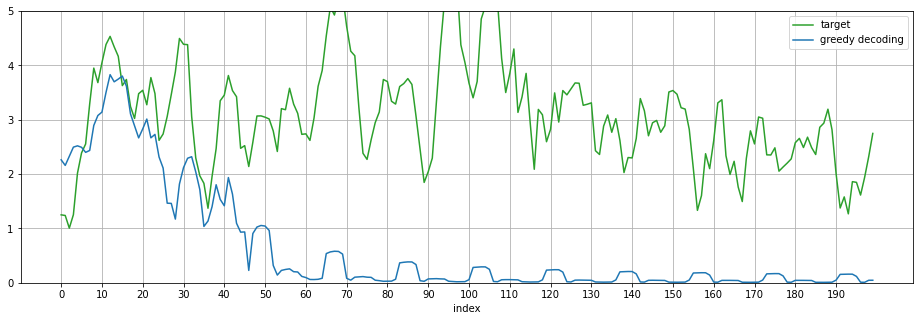

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)
lpdh['dent_cumsum'] = lpdh['dent'].cumsum()

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=greedy_sample, width=5, max_len=MAX_LEN, 
)
greedy_labeled_datapoint['dent_cumsum'] = greedy_labeled_datapoint['dent'].cumsum()

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=beam_sample, width=5, max_len=MAX_LEN,
)
beam_labeled_datapoint['dent'] = beam_labeled_datapoint['dent'].cumsum()

# plot_avg_entropies_mean_std(human_ma_entropies[:], ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh[:200].plot(x="index", y='entropy_ma', ylim=(-0,5), ax=ax, label='target', color='tab:green')


greedy_labeled_datapoint[:200].plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:blue')
# greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:orange')

ax.set_xticks(np.arange(len(greedy_labeled_datapoint[:200]['index']), step=10))
plt.grid()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "<n>"))
print()

In [ ]:
greedy_labeled_datapoint['token'][20:50]

20         Ġto
21         Ġbe
22       Ġable
23         Ġto
24       Ġhold
25        Ġher
26         Ġin
27         Ġmy
28       Ġarms
29           .
30          ĠI
31        Ġwas
32         Ġso
33    Ġexcited
34         Ġto
35        Ġsee
36        Ġher
37           ,
38         Ġto
39         Ġbe
40       Ġable
41         Ġto
42       Ġhold
43        Ġher
44         Ġin
45         Ġmy
46       Ġarms
47           .
48          ĠI
49        Ġwas
Name: token, dtype: object

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")

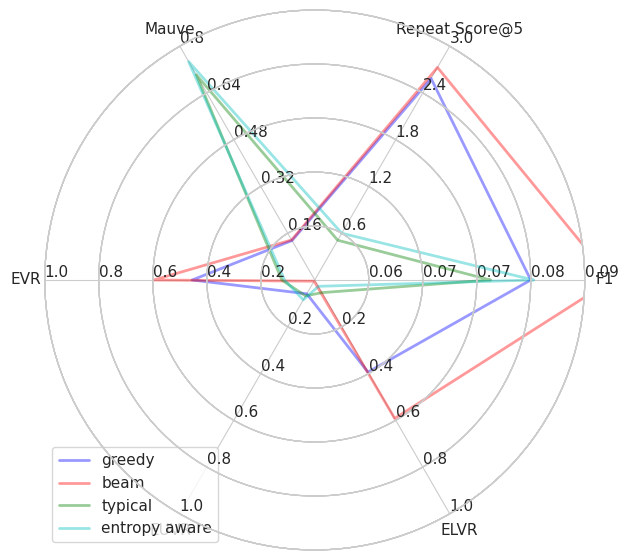

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))
        
        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


if __name__ == "__main__":
    # example data
    variables = ("F1", "Repeat Score@5", "Mauve", 
                "EVR", "EUVR", "ELVR")
    ranges = [(0.05, 0.09), (0, 3), (0, 0.8),
            (0, 1), (0, 1), (0, 1)]
    greedy = (0.082, 2.585, 0.135, 0.454, 0.059, 0.394)
    beam = (0.094, 2.727, 0.137, 0.596, 0.005, 0.592)
    typical = (0.076, 0.51, 0.702, 0.122, 0.068, 0.054)
    entropy_aware = (0.0824,0.6, 0.747, 0.112, 0.085, 0.027)
    # plotting
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, ranges)
    radar.plot(greedy,  lw=2, color="b", alpha=0.4, label="greedy")
    # radar.fill(greedy, alpha=0.2)

    radar.plot(beam,  lw=2, color="r", alpha=0.4, label="beam")
    # radar.fill(beam, alpha=0.2)

    radar.plot(typical,  lw=2, color="g", alpha=0.4, label="typical")
    # radar.fill(typical, alpha=0.2)

    radar.plot(entropy_aware,  lw=2, color="c", alpha=0.4, label="entropy aware")
    # radar.fill(entropy_aware, alpha=0.2)
    radar.ax.legend()